In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

In [9]:
from scipy.ndimage.morphology import binary_fill_holes

from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

In [271]:
def cal_lifetimes_angle(mask_img, plot=True):
    lifetimes = analysis.cal_lifetimes(mask_img, save=False)
    lifetimes = lifetimes[-1].astype(float)
    t1 = lifetimes.copy()
    t1[t1<60] = 0
    t1 = t1.astype('uint8')
    t1_center = regionprops(t1)[0].centroid
    t2 = lifetimes.copy()
    t2[t2>20] = 0
    t2 = t2.astype('uint8')
    t2_center = regionprops(t2)[0].centroid

    x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])

    if plot:
        y1,x1 = int(t1_center[-2]),int(t1_center[-1])
        y2,x2 = int(t2_center[-2]),int(t2_center[-1])
        t_plot = lifetimes.sum(axis=0)
        t_plot[t_plot!=0] = 1
        t_plot[y1-1:y1+1,x1-1:x1+1]=5
        t_plot[y2-1:y2+1,x2-1:x2+1]=10
        plt.imshow(t_plot)
        plt.plot((x1,x2),(y1,y2))
    return x, y, np.degrees(np.arctan2(y,x))


In [ ]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/output/'
subtype = 'B'
# stab_limit = 5 #(No. of timepoints for stable branches calculation)
start_age = 37

In [ ]:
# getting list of folders in data_path, where each folder has files for one neuron
N_folders = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '_P' in f]
N_folders = sorted(N_folders)
N_folders

In [ ]:
result_cols = ['neuron','X','Y','angle']
results = pd.DataFrame(columns=result_cols)
for n_folder in N_folders:
    start_im = re.search('P(.*)_N', n_folder)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    files_list = datautils.get_file_names(data_path+n_folder, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='')
    neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
    neuron = tif.imread(neu_path)
    mask_path = [f for f in files_list if 'mask' in f.lower()][0]
    mask = tif.imread(mask_path)
    neuron[mask==0] = 0
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    x,y,res_angle = cal_lifetimes_angle(neuron, plot=True)
    results[n_folder]=[n_folder,x,y,res_angle]

In [275]:
# neuron = 
mask = tif.imread('/Users/aichah/Desktop/TLI/data/test_data/211113_P36_N1_mask3_JESUS.tif')

100%|██████████| 85/85 [00:04<00:00, 17.03it/s]


128.32690701918526

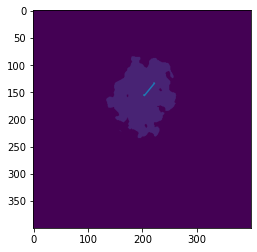

In [276]:
cal_lifetimes_angle(mask)

In [264]:
lifetimes = analysis.cal_lifetimes(mask, save=False)

100%|██████████| 87/87 [00:04<00:00, 17.45it/s]


(0.0, 90.0)

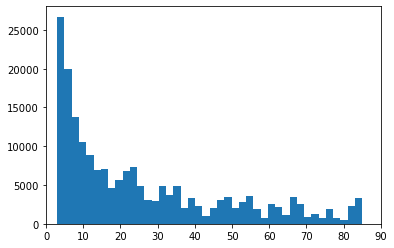

In [265]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>2]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(0,90)

(4.0, 90.0)

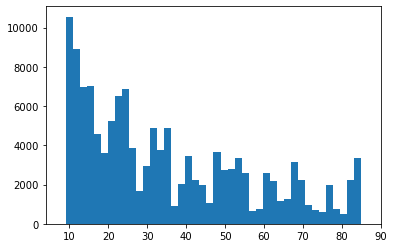

In [266]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

(4.0, 90.0)

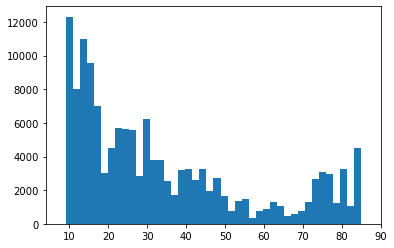

In [255]:
# test = lifetimes[-1].astype('uint8')
# t = test[test>0]
# plt.hist(t,bins=int(t.max()/2))

test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

(4.0, 90.0)

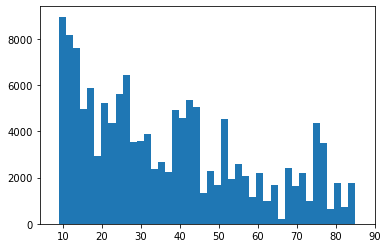

In [251]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

In [219]:
lifetimes.shape

(89, 37, 400, 400)

In [87]:
test = lifetimes[-1]
test = test.astype('float')
test = test/4
test -= test.max()
test = test * -1
# test += test.min()
# test[test < 5] = np.nan

In [88]:
test.max(), test.min()

(22.25, -0.0)

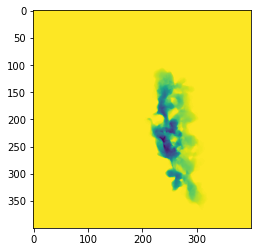

In [103]:
test2 = np.mean(test, axis=0)
test2[test2<10]=0
plt.imshow(test2)

In [121]:
test = lifetimes[-1].astype('uint8')
test_region = regionprops(test)[0]

In [130]:
test_region.centroid

(36.56324522638206, 230.88815698046082, 267.2552322187943)

In [123]:
test_region.centroid_weighted

AttributeError: '<class 'skimage.measure._regionprops.RegionProperties'>' object has no attribute 'centroid_weighted'

In [124]:
from skimage.measure import moments_central, moments
M = moments(test)
centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0])
# moments_central(image, centroid)

In [125]:
centroid

(array([34.74915063, 34.79952865, 34.85318139, 34.91002107]),
 array([227.59680551, 229.33249498, 231.1400795 , 233.01540956]))

In [127]:
test.max()

89

In [185]:
import cv2
test=lifetimes[-1]
test = test.astype(float)
t = np.mean(test, axis=0)
t[t>0] = np.reciprocal(t[t>0])
# t = np.reciprocal(t)
# t[t>0] -= t.max()
# t = t * -1
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(234.7540002025629, 270.74278274247416)

In [168]:
test_region.centroid

(36.56324522638206, 230.88815698046082, 267.2552322187943)

In [173]:
import cv2
test = mask[-1]
test = test.astype(float)

# t = test.sum(axis=0)
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(nan, nan)

In [187]:
x,y = (267.25-234.75) , (230.89-270.75)
np.degrees(np.arctan2(y,x))

-50.80778956198833

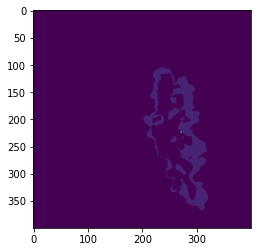

In [194]:
t[t!=0] = 1
# t[234:236,269:271]=10
t[223:225,271:273]=10
plt.imshow(t)

In [191]:
import cv2
test=lifetimes[-1]
test = test.astype(float)
t = np.mean(test, axis=0)
t[t>5] = 0
# plt.imshow(t)
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(224.56065958693225, 272.3185131844901)

In [179]:
np.reciprocal(t[t>0]).max()

56.0

In [180]:
t[t>0] = np.reciprocal(t[t>0])

In [220]:
test = lifetimes[-1].astype(float)
# test = test/4
t1 = test.copy()
t1[t1<60] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = test.copy()
t2[t2>20] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid
t1_center, t2_center

((18.499021526418787, 78.06457925636008, 275.4021526418787),
 (18.473759870817826, 108.90348752486166, 259.157224158642))

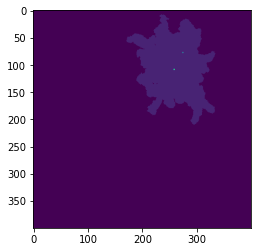

In [221]:
t_plot = test.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[77:79,274:276]=5
t_plot[108:110,258:260]=10
plt.imshow(t_plot)

In [222]:
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
np.degrees(np.arctan2(y,x))

117.77879489919786

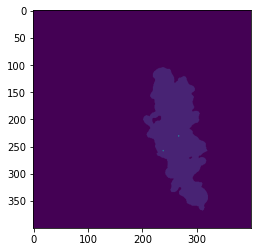

In [216]:
t_plot = test.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[257:259,238:240]=5
t_plot[230:232,267:268]=10
plt.imshow(t_plot)

In [206]:
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
np.degrees(np.arctan2(y,x))

-44.15026086389054

In [23]:
test[test==1].sum(),test[test==2].sum()/2, test[test==4].sum()/4, test[test==10].sum()/10

(35979.0, 19854.0, 10192.0, 3880.0)

In [215]:
test = lifetimes[-1]
test = test.astype('uint16')
test_region = regionprops(test,intensity_image=test)[0]
test_region.centroid_weighted, test_region.centroid

((36.56324522638205, 230.88815698046082, 267.2552322187943),
 (36.56324522638206, 230.88815698046082, 267.2552322187943))

In [8]:
test = np.array([1,0,0,1,1])
binary_fill_holes(test).astype(int)

array([1, 1, 1, 1, 1, 1])

For explanation of the the individual columns in the result csv file, expand the next cell

In [2]:
"""" Results' columns' description 
'neuron':  neuron name extracted from file name
'subtype': neuron name extracted from file name
'entry_point': entry point of the neuron, read from seperate txt file

'volume': number of pixels in the 3D masked image
'net_area': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)
'area': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)
'AP_spread': (max-min) of value pixels index in last (x) dimension of the 2D image
'DV_spread': (max-min) of value pixels index in (y) dimension of the 2D image

'density_2D': solidity value obtained from skimage.measure.regionprops on the 2D image
'density_3D': pixel count of 3D image/pixel count of 3D convexhull 
'object_perimeter': object perimenter value obtained from skimage.measure.regionprops on the 2D image
'convex_perimeter': perimeter of the surronding convex_hull

'circularity': (4*np.pi*convex_area)/(convex_perimeter**2)
'compactness': object_perimeter**2/(4*np.pi*net_area)
'surface_area': mesh_surface_area of the marching_cubes on the 3D masked image
'eccentricity': eccentricity value obtained from skimage.measure.regionprops on the 2D image 
>>>> change to 3D >>>>  'convexity': convex_perimeter/object_perimeter (maybe try surface_area/3D_image_convex_surface area)
'orientation': orientation value obtained from skimage.measure.regionprops on the 2D image 
'feret_diameter_max': feret_diameter_max value obtained from skimage.measure.regionprops on the 2D image 
'DGI':

'centroidZ': Z position of the centroid from regionprops on the 3D masked image 
'centroidY': Y position of the centroid from regionprops on the 3D masked image 
'centroidX': X position of the centroid from regionprops on the 3D masked image 
'cen_EP_dis': ecludian distance of the centroid from the entry point
'cen_EP_angle': angle of the line between centroid from the entry point (np.arctan2)

£££ PCA analysis
'asymmetry':
'xP_weight', 'xP_scale','xP_angle','xP_xy':
'xN_weight','xN_scale','xN_angle','xN_xy',
'yP_weight','yP_scale','yP_angle','yP_xy',
'yN_weight','yN_scale','yN_angle','yN_xy',
'PCA_angle':
'PCA_xy':
'PCA_shift_centroid':
"""

'" Results\' columns\' description \n\'neuron\':  neuron name extracted from file name\n\'subtype\': neuron name extracted from file name\n\'entry_point\': entry point of the neuron, read from seperate txt file\n\n\'volume\': number of pixels in the 3D masked image\n\'net_area\': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)\n\'area\': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)\n\'AP_spread\': (max-min) of value pixels index in last (x) dimension of the 2D image\n\'DV_spread\': (max-min) of value pixels index in (y) dimension of the 2D image\n\n\'density_2D\': solidity value obtained from skimage.measure.regionprops on the 2D image\n\'density_3D\': pixel count of 3D image/pixel count of 3D convexhull \n\'object_perimeter\': object perimenter value obtained from skimage.measure.regionprops on the 2D image\n\'convex_perimeter\': perimeter of the surronding convex_hull\n\n\'circularity\': (4*np.pi*conv

In [3]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

In [4]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/output/'
subtype = 'B'
# stab_limit = 5 #(No. of timepoints for stable branches calculation)
start_age = 37

In [5]:
# getting list of folders in data_path, where each folder has files for one neuron
N_folders = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '_P' in f]
N_folders = sorted(N_folders)
N_folders

['211011_P37_N1', '211107_P36_N1']

In [6]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/home/tli_project/Desktop/Data/T4/neurons/TLI_stage1_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [7]:
results_cols = ['timepoint', 'volume', '3D_convex_volume', 'net_area', 'area',
                'AP_spread', 'DV_spread',
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'circularity', 'compactness', 'surface_area', '3D_convex_surface',
                'eccentricity', 'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max',
                'DGI',
                'centroidZ','centroidY', 'centroidX', 
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_Y','cen_EP_X',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PC1_angle','PC1_x','PC1_y']
# results_df = pd.DataFrame(columns=results_cols)
# for i in range(100):
#     results_df.loc[start_age+i*0.25] = [None for col in results_df.columns]

In [8]:
def process_image(n_file):
    neuron_results = pd.DataFrame(columns=results_cols)
    entry_point = entry_points[n_file][1:] # remove the first T element
    start_im = re.search('P(.*)_N', n_file)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    files_list = datautils.get_file_names(data_path+n_file, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='')
    neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
    neuron = tif.imread(neu_path)
    mask_path = [f for f in files_list if 'mask' in f.lower()][0]
    mask = tif.imread(mask_path)
    neuron[mask==0] = 0
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    neu_2D = neuron.max(axis=1)
    neuron_results['timepoint'] = [start_age+i*0.25 for i in range(len(neu_2D))]
    neuron_results['volume'] = neuron.sum(axis=tuple(np.arange(len(neuron.shape))[1:]))
    neuron_results['net_area'] = neu_2D.sum(axis=tuple(np.arange(len(neu_2D.shape))[1:]))
    for t, stack in enumerate(neuron):
        reg_prop_2D = regionprops(neu_2D[t])[0]
        reg_prop_3D = regionprops(stack)[0]
        neuron_results.loc[t,'density_2D'] = reg_prop_2D.solidity
        neuron_results.loc[t,'area'] = reg_prop_2D.area_convex
        neuron_results.loc[t,'orientation'] = reg_prop_2D.orientation
        neuron_results.loc[t,'eccentricity'] = reg_prop_2D.eccentricity
        neuron_results.loc[t,'feret_diameter_max'] = reg_prop_2D.feret_diameter_max
        neuron_results.loc[t,'convex_perimeter'] = perimeter(reg_prop_2D.image_convex)
        neuron_results.loc[t,'object_perimeter'] = reg_prop_2D.perimeter
        neuron_results.loc[t,['centroidZ','centroidY','centroidX']] = reg_prop_3D.centroid
        neuron_results.loc[t,'3D_convex_volume'] = reg_prop_3D.area_convex
        neuron_results.loc[t,'density_3D'] = neuron_results.loc[t,'volume']/neuron_results.loc[t,'3D_convex_volume']
        img_PC = reg_prop_3D.coords
        neuron_results.loc[t,'DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*0.076
        neuron_results.loc[t,'AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*0.076
        centroid_EP = np.array(entry_point)-np.array(reg_prop_3D.centroid)
        neuron_results.loc[t,'cen_EP_dis'] = np.linalg.norm(centroid_EP[1:])
        neuron_results.loc[t,['cen_EP_Y','cen_EP_X']] = centroid_EP[1:]
        p1 = (centroid_EP[1],centroid_EP[2])
        neuron_results.loc[t,'cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))

        verts, faces, normals, values = marching_cubes(stack, step_size=2, spacing=(0.4,0.076,0.076))
        neuron_results.loc[t,'surface_area'] = mesh_surface_area(verts, faces)
        convex_img_3D = reg_prop_3D.image_convex.astype('uint8')
        verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
        neuron_results.loc[t,'3D_convex_surface'] = mesh_surface_area(verts, faces)
        neuron_results.loc[t,'convexity_3D'] = neuron_results.loc[t,'3D_convex_surface']/neuron_results.loc[t,'surface_area']

        asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(neu_2D[t],entry_point[1:],plot=False)
        asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
        neuron_results.loc[t,asymmetries]  = asymmetry_values

        PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                    'xN_weight','xN_scale','xN_angle','xN_xy',
                    'yP_weight','yP_scale','yP_angle','yP_xy',
                    'yN_weight','yN_scale','yN_angle','yN_xy']
        PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
        neuron_results.loc[t,PCA_res]  = PCA_arr.ravel()
        neuron_results.loc[t,'PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
        neuron_results.loc[t,'PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
        neuron_results.loc[t,'PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]
        # neuron_results.loc[t,'PC1_shift_centroid'] = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
        
        neuron_results.loc[t,'DGI'] = analysis.DGI_3D(stack,entry_point)

    neuron_results['convexity_2D'] = neuron_results['convex_perimeter']/neuron_results['object_perimeter']
    neuron_results['circularity'] = (4*np.pi*neuron_results['area'])/(neuron_results['convex_perimeter']**2)
    neuron_results['compactness'] = neuron_results['object_perimeter']#     p = Pool(cpu_count()-1)
    csv_name = save_path+n_file+'_s'+subtype+'.csv'
    neuron_results.to_csv(csv_name)
    return neuron_results

# if __name__ == '__main__':
#     # c = cpu_count()-1
#     with Pool(3) as p:
#         p.map(process_image, N_folders)

for n_file in tqdm(N_folders):
    process_image(n_file)

  0%|          | 0/2 [00:00<?, ?it/s]

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/test_line.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_3.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_2.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_10.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/mywarpedgrid_3.png']


In [ ]:
# for i, n_file in tqdm(enumerate(N_folders)):
#     neuron_results = pd.DataFrame(columns=results_cols)
#     entry_point = entry_points[n_file][1:]
#     start_im = re.search('P(.*)_N', n_file)
#     start_im = float(start_im.group(1))
#     start_ana = int((start_age - start_im)/0.25)
#     files_list = datautils.get_file_names(data_path+n_file, group_by='', 
#                                         order=True, nested_files=False, 
#                                         criteria='')
#     neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
#     neuron = tif.imread(neu_path)
#     mask_path = [f for f in files_list if 'mask' in f.lower()][0]
#     mask = tif.imread(mask_path)
#     neuron[mask==0] = 0
#     neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
#     neuron[neuron != 0] = 1
#     neu_2D = neuron.max(axis=1)
#     neu_2D = neuron.max(axis=1)
#     neuron_results['timepoint'] = [start_age+i*0.25 for i in range(len(neu_2D))]
#     neuron_results['volume'] = neuron.sum(axis=tuple(np.arange(len(neuron.shape))[1:]))
#     neuron_results['net_area'] = neu_2D.sum(axis=tuple(np.arange(len(neu_2D.shape))[1:]))

#     reg_prop_2D = []
#     reg_prop_3D = []
#     for t, stack in enumerate(neuron):
#         reg_prop_2D.append(regionprops(neu_2D[t])[0])
#         reg_prop_3D.append(regionprops(stack)[0])
#         img_PC = reg_prop_3D[t].coords
#         neuron_results.loc[t,'DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*0.076
#         neuron_results.loc[t,'AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*0.076
#         neuron_results.loc[t,'density_3D'] = neuron_results.loc[t,'volume']/regionprops(stack)[0].area_convex

#         verts, faces, normals, values = marching_cubes(stack, step_size=2, spacing=(0.4,0.076,0.076))
#         neuron_results.loc[t,'surface_area'] = mesh_surface_area(verts, faces)
#         convex_img_3D = reg_prop_3D[t].image_convex.astype('uint8')
#         verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
#         neuron_results.loc[t,'convexity_3D'] = mesh_surface_area(verts, faces)/neuron_results.loc[t,'surface_area']

#         asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(neu_2D[t],entry_point[1:],plot=False)
#         asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
#         neuron_results.loc[t,asymmetries]  = asymmetry_values

#         PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
#                     'xN_weight','xN_scale','xN_angle','xN_xy',
#                     'yP_weight','yP_scale','yP_angle','yP_xy',
#                     'yN_weight','yN_scale','yN_angle','yN_xy']
#         PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
#         neuron_results.loc[t,PCA_res]  = PCA_arr.ravel()
#         neuron_results.loc[t,'PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
#         neuron_results.loc[t,'PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
#         neuron_results.loc[t,'PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]

#         neuron_results.loc[t,['centroidZ','centroidY','centroidX']] = reg_prop_3D[t].centroid
#         centroid_EP = np.array(entry_point)-np.array(reg_prop_3D[t].centroid)
#         neuron_results.loc[t,'cen_EP_dis'] = np.linalg.norm(centroid_EP[1:])
#         neuron_results.loc[t,['cen_EP_Y','cen_EP_X']] = centroid_EP[1:]
#         p1 = (centroid_EP[1],centroid_EP[2])
#         neuron_results.loc[t,'cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))


#     del neuron, neu_2D
#     neuron_results['density_2D'] = [r.solidity for r in reg_prop_2D]
#     # neuron_results['density_3D'] = [r.area_convex for r in reg_prop_3D]
#     # neuron_results['density_3D'] = neuron_results.loc[t,'volume']/neuron_results['density_3D']
#     neuron_results['area'] = [r.area_convex for r in reg_prop_2D]
#     neuron_results['orientation'] = [r.orientation for r in reg_prop_2D]
#     neuron_results['eccentricity'] = [r.eccentricity for r in reg_prop_2D]
#     neuron_results['feret_diameter_max'] = [r.feret_diameter_max for r in reg_prop_2D]
#     neuron_results['convex_perimeter'] = [perimeter(r.image_convex) for r in reg_prop_2D]
#     neuron_results['object_perimeter'] = [r.perimeter for r in reg_prop_2D]
#     neuron_results['convexity_2D'] = neuron_results['convex_perimeter']/neuron_results['object_perimeter']
#     neuron_results['circularity'] = (4*np.pi*neuron_results['area'])/(neuron_results['convex_perimeter']**2)
#     neuron_results['compactness'] = neuron_results['object_perimeter']**2/(4*np.pi*neuron_results['net_area'])
#     del reg_prop_2D, reg_prop_3D

#     csv_name = save_path+n_file+'_s'+subtype+'_new_111.csv'
#     neuron_results.to_csv(csv_name)